In [15]:
## 1. 라이브러리 불러오기

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import random
import torch.nn.functional as F
# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)

# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치: {device}")

print("기본 라이브러리 로드 완료")

사용 장치: cuda
기본 라이브러리 로드 완료


In [10]:
class GMF(nn.Module):
    """
    일반화된 행렬 분해 (Generalized Matrix Factorization) 모델
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, latent_dim=64):
        super(GMF, self).__init__()
        
        # 인덱스 범위 안전을 위한 여유 마진 추가
        print(f"GMF 초기화: num_users={num_users}, num_items={num_items}")
        # 임베딩 레이어에 여유 공간 추가
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        self.user_id_embed = nn.Embedding(num_users, latent_dim)
        self.item_id_embed = nn.Embedding(num_items, latent_dim)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc = nn.Linear(user_embed_dim, latent_dim)
        self.item_text_fc = nn.Linear(item_embed_dim, latent_dim)
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(latent_dim, 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed.weight, std=0.01)
        nn.init.normal_(self.item_id_embed.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc.weight)
        nn.init.xavier_uniform_(self.item_text_fc.weight)
        nn.init.xavier_uniform_(self.predict_layer.weight)
        
        # 바이어스 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # ID 임베딩
        user_id_latent = self.user_id_embed(user_id)  # (batch_size, latent_dim)
        item_id_latent = self.item_id_embed(item_id)  # (batch_size, latent_dim)
        
        # 텍스트 임베딩 투영
        user_text_latent = self.user_text_fc(user_embed)  # (batch_size, latent_dim)
        item_text_latent = self.item_text_fc(item_embed)  # (batch_size, latent_dim)
        
        # 임베딩 결합 (ID + 텍스트)
        user_latent = user_id_latent + user_text_latent  # (batch_size, latent_dim)
        item_latent = item_id_latent + item_text_latent  # (batch_size, latent_dim)
        
        # 요소별 곱 (Hadamard product)
        element_product = user_latent * item_latent  # (batch_size, latent_dim)
        
        # 출력층
        logits = self.predict_layer(element_product)  # (batch_size, 1)
        rating = self.sigmoid(logits)  # (batch_size, 1)
        
        return rating.view(-1)

class MLP(nn.Module):
    """
    다층 퍼셉트론 (Multi-Layer Perceptron) 모델
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, latent_dim=64, layers=[128, 64, 32]):
        """
        Args:
            num_users (int): 사용자 수
            num_items (int): 아이템 수
            user_embed_dim (int): 사용자 임베딩 차원
            item_embed_dim (int): 아이템 임베딩 차원
            latent_dim (int): 잠재 요인 차원
            layers (list): MLP 레이어 구성
        """
        super(MLP, self).__init__()

        print(f"MLP 초기화: num_users={num_users}, num_items={num_items}")
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        # 임베딩 레이어
        self.user_id_embed = nn.Embedding(num_users, latent_dim)
        self.item_id_embed = nn.Embedding(num_items, latent_dim)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc = nn.Linear(user_embed_dim, latent_dim)
        self.item_text_fc = nn.Linear(item_embed_dim, latent_dim)
        
        # MLP 레이어
        self.fc_layers = nn.ModuleList()
        input_dim = latent_dim * 2
        
        for layer_size in layers:
            self.fc_layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(layers[-1], 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed.weight, std=0.01)
        nn.init.normal_(self.item_id_embed.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc.weight)
        nn.init.xavier_uniform_(self.item_text_fc.weight)
        
        # MLP 레이어 초기화
        for m in self.fc_layers:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
        # 예측 레이어 초기화
        nn.init.xavier_uniform_(self.predict_layer.weight)
        nn.init.constant_(self.predict_layer.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # ID 임베딩
        user_id_latent = self.user_id_embed(user_id)  # (batch_size, latent_dim)
        item_id_latent = self.item_id_embed(item_id)  # (batch_size, latent_dim)
        
        # 텍스트 임베딩 투영
        user_text_latent = self.user_text_fc(user_embed)  # (batch_size, latent_dim)
        item_text_latent = self.item_text_fc(item_embed)  # (batch_size, latent_dim)
        
        # 임베딩 결합 (ID + 텍스트)
        user_latent = user_id_latent + user_text_latent  # (batch_size, latent_dim)
        item_latent = item_id_latent + item_text_latent  # (batch_size, latent_dim)
        
        # 벡터 연결 (Concatenation)
        vector = torch.cat([user_latent, item_latent], dim=-1)  # (batch_size, latent_dim*2)
        
        # MLP 레이어
        for idx, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = F.relu(vector)
        
        # 출력층
        logits = self.predict_layer(vector)  # (batch_size, 1)
        rating = self.sigmoid(logits)  # (batch_size, 1)
        
        return rating.view(-1)

class NeuMF(nn.Module):
    """
    신경망 기반 행렬 분해 (Neural Matrix Factorization) 모델
    GMF와 MLP의 결합
    """
    def __init__(self, num_users, num_items, user_embed_dim, item_embed_dim, 
                 latent_dim_gmf=64, latent_dim_mlp=64, layers=[128, 64, 32], 
                 use_text_embed=True, use_id_embed=True):
        """
        Args:
            num_users (int): 사용자 수
            num_items (int): 아이템 수
            user_embed_dim (int): 사용자 임베딩 차원
            item_embed_dim (int): 아이템 임베딩 차원
            latent_dim_gmf (int): GMF 잠재 요인 차원
            latent_dim_mlp (int): MLP 잠재 요인 차원
            layers (list): MLP 레이어 구성
            use_text_embed (bool): 텍스트 임베딩 사용 여부
            use_id_embed (bool): ID 임베딩 사용 여부
        """
        super(NeuMF, self).__init__()
        
        # 설정 저장
        self.use_text_embed = use_text_embed
        self.use_id_embed = use_id_embed

        # 인덱스 범위 안전을 위한 여유 마진 추가
        print(f"NeuMF 초기화: num_users={num_users}, num_items={num_items}")
        # 임베딩 레이어에 여유 공간 추가
        num_users = max(num_users, 30000)  # 충분히 큰 값으로 설정
        num_items = max(num_items, 10000)  # 충분히 큰 값으로 설정
        
        # GMF 임베딩 레이어
        self.user_id_embed_gmf = nn.Embedding(num_users, latent_dim_gmf)
        self.item_id_embed_gmf = nn.Embedding(num_items, latent_dim_gmf)
        
        # MLP 임베딩 레이어
        self.user_id_embed_mlp = nn.Embedding(num_users, latent_dim_mlp)
        self.item_id_embed_mlp = nn.Embedding(num_items, latent_dim_mlp)
        
        # 사용자/아이템 텍스트 임베딩을 위한 선형 레이어
        self.user_text_fc_gmf = nn.Linear(user_embed_dim, latent_dim_gmf)
        self.item_text_fc_gmf = nn.Linear(item_embed_dim, latent_dim_gmf)
        self.user_text_fc_mlp = nn.Linear(user_embed_dim, latent_dim_mlp)
        self.item_text_fc_mlp = nn.Linear(item_embed_dim, latent_dim_mlp)
        
        # MLP 레이어
        self.fc_layers = nn.ModuleList()
        input_dim = latent_dim_mlp * 2
        
        for layer_size in layers:
            self.fc_layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size
        
        # 최종 예측 레이어
        self.predict_layer = nn.Linear(layers[-1] + latent_dim_gmf, 1)
        
        # 활성화 함수
        self.sigmoid = nn.Sigmoid()
        
        # 가중치 초기화
        self._init_weight()
        
    def _init_weight(self):
        """
        가중치 초기화
        """
        # 임베딩 레이어 초기화
        nn.init.normal_(self.user_id_embed_gmf.weight, std=0.01)
        nn.init.normal_(self.item_id_embed_gmf.weight, std=0.01)
        nn.init.normal_(self.user_id_embed_mlp.weight, std=0.01)
        nn.init.normal_(self.item_id_embed_mlp.weight, std=0.01)
        
        # 선형 레이어 초기화
        nn.init.xavier_uniform_(self.user_text_fc_gmf.weight)
        nn.init.xavier_uniform_(self.item_text_fc_gmf.weight)
        nn.init.xavier_uniform_(self.user_text_fc_mlp.weight)
        nn.init.xavier_uniform_(self.item_text_fc_mlp.weight)
        
        # MLP 레이어 초기화
        for m in self.fc_layers:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
        # 예측 레이어 초기화
        nn.init.xavier_uniform_(self.predict_layer.weight)
        nn.init.constant_(self.predict_layer.bias, 0)
        
    def forward(self, user_id, item_id, user_embed, item_embed):
        """
        순전파
        
        Args:
            user_id (torch.Tensor): 사용자 ID 텐서
            item_id (torch.Tensor): 아이템 ID 텐서
            user_embed (torch.Tensor): 사용자 임베딩 텐서
            item_embed (torch.Tensor): 아이템 임베딩 텐서
            
        Returns:
            torch.Tensor: 예측값 (0-1)
        """
        # GMF 임베딩
        user_id_latent_gmf = self.user_id_embed_gmf(user_id)
        item_id_latent_gmf = self.item_id_embed_gmf(item_id)
        
        # MLP 임베딩
        user_id_latent_mlp = self.user_id_embed_mlp(user_id)
        item_id_latent_mlp = self.item_id_embed_mlp(item_id)
        
        # 텍스트 임베딩 투영
        user_text_latent_gmf = self.user_text_fc_gmf(user_embed)
        item_text_latent_gmf = self.item_text_fc_gmf(item_embed)
        user_text_latent_mlp = self.user_text_fc_mlp(user_embed)
        item_text_latent_mlp = self.item_text_fc_mlp(item_embed)
        
        # 임베딩 결합 (ID + 텍스트)
        if self.use_id_embed and self.use_text_embed:
            # ID와 텍스트 임베딩 모두 사용
            user_latent_gmf = user_id_latent_gmf + user_text_latent_gmf
            item_latent_gmf = item_id_latent_gmf + item_text_latent_gmf
            user_latent_mlp = user_id_latent_mlp + user_text_latent_mlp
            item_latent_mlp = item_id_latent_mlp + item_text_latent_mlp
        elif self.use_id_embed:
            # ID 임베딩만 사용
            user_latent_gmf = user_id_latent_gmf
            item_latent_gmf = item_id_latent_gmf
            user_latent_mlp = user_id_latent_mlp
            item_latent_mlp = item_id_latent_mlp
        elif self.use_text_embed:
            # 텍스트 임베딩만 사용
            user_latent_gmf = user_text_latent_gmf
            item_latent_gmf = item_text_latent_gmf
            user_latent_mlp = user_text_latent_mlp
            item_latent_mlp = item_text_latent_mlp
        else:
            # 최소한 하나의 임베딩은 사용해야 함
            raise ValueError("최소한 ID 임베딩 또는 텍스트 임베딩 중 하나는 사용해야 합니다.")
        
        # GMF 부분: 요소별 곱 (Hadamard product)
        gmf_vector = user_latent_gmf * item_latent_gmf
        
        # MLP 부분: 벡터 연결 (Concatenation) + MLP
        mlp_vector = torch.cat([user_latent_mlp, item_latent_mlp], dim=-1)
        
        for idx, layer in enumerate(self.fc_layers):
            mlp_vector = layer(mlp_vector)
            mlp_vector = F.relu(mlp_vector)
        
        # GMF와 MLP 결과 결합
        vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        
        # 출력층
        logits = self.predict_layer(vector)
        rating = self.sigmoid(logits)
        
        return rating.view(-1)

In [11]:
## 2. 데이터 및 모델 로드

# 경로 설정
PROCESSED_DIR = "./data/processed"
EMBEDDINGS_DIR = "./data/embeddings"
TRUST_DIR = "./data/trust"
MODELS_DIR = "./models"
RESULTS_DIR = "./results"

# 디렉토리 생성
os.makedirs(RESULTS_DIR, exist_ok=True)

# 학습된 모델 및 결과 로드
with open(os.path.join(MODELS_DIR, "final_results.pkl"), 'rb') as f:
    final_results = pickle.load(f)
print("학습 결과 로드 완료")

# 테스트 데이터 로드
with open(os.path.join(PROCESSED_DIR, "test_df.pkl"), 'rb') as f:
    test_df = pickle.load(f)
print(f"테스트 데이터 로드 완료: {len(test_df):,}개 항목")

# 비즈니스 데이터 로드
with open(os.path.join(PROCESSED_DIR, "business_processed.pkl"), 'rb') as f:
    business_processed = pickle.load(f)
print(f"비즈니스 데이터 로드 완료: {len(business_processed):,}개 항목")

# 임베딩 데이터 로드
with open(os.path.join(EMBEDDINGS_DIR, "test_item_embeddings.pkl"), 'rb') as f:
    test_item_embeddings = pickle.load(f)
with open(os.path.join(EMBEDDINGS_DIR, "test_user_embeddings.pkl"), 'rb') as f:
    test_user_embeddings = pickle.load(f)
with open(os.path.join(EMBEDDINGS_DIR, "enhanced_item_embeddings.pkl"), 'rb') as f:
    enhanced_item_embeddings = pickle.load(f)
print("임베딩 데이터 로드 완료")

# 신뢰도 점수 데이터 로드
with open(os.path.join(TRUST_DIR, "user_trust_scores.pkl"), 'rb') as f:
    user_trust_scores = pickle.load(f)
print(f"사용자 신뢰도 점수 로드 완료: {len(user_trust_scores):,}개 항목")

# 결과 확인
baseline_results = final_results['baseline_results']
variant_results = final_results['variant_results']
best_model_name = final_results['best_model_name']
best_model = final_results['best_model']

print(f"베이스라인 모델 수: {len(baseline_results)}")
print(f"모델 변형 수: {len(variant_results)}")
print(f"최적 모델: {best_model_name}")

학습 결과 로드 완료
테스트 데이터 로드 완료: 1,748개 항목
비즈니스 데이터 로드 완료: 7,044개 항목
임베딩 데이터 로드 완료
사용자 신뢰도 점수 로드 완료: 430개 항목
베이스라인 모델 수: 3
모델 변형 수: 4
최적 모델: NeuMF_ID_Text_Trust



=== 모델 성능 요약 ===
                 Model  Category  Test Loss    NDCG@K  HR@K       MRR  \
0        NeuMF_ID_only   Variant   0.063825  1.000000   1.0  1.000000   
1        NeuMF_ID_Text   Variant   0.073785  1.000000   1.0  1.000000   
2                  GMF  Baseline   0.083596  0.999694   1.0  0.999585   
3                  MLP  Baseline   0.082949  0.999694   1.0  0.999585   
4                NeuMF  Baseline   0.083708  0.999694   1.0  0.999585   
5      NeuMF_Text_only   Variant   0.086729  0.999694   1.0  0.999585   
6  NeuMF_ID_Text_Trust   Variant   0.068897  0.999694   1.0  0.999585   

              Description  
0              ID 임베딩만 사용  
1            ID + 텍스트 임베딩  
2                     GMF  
3                     MLP  
4                   NeuMF  
5             텍스트 임베딩만 사용  
6  ID + 텍스트 임베딩 + 신뢰도 가중치  


C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:99: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\

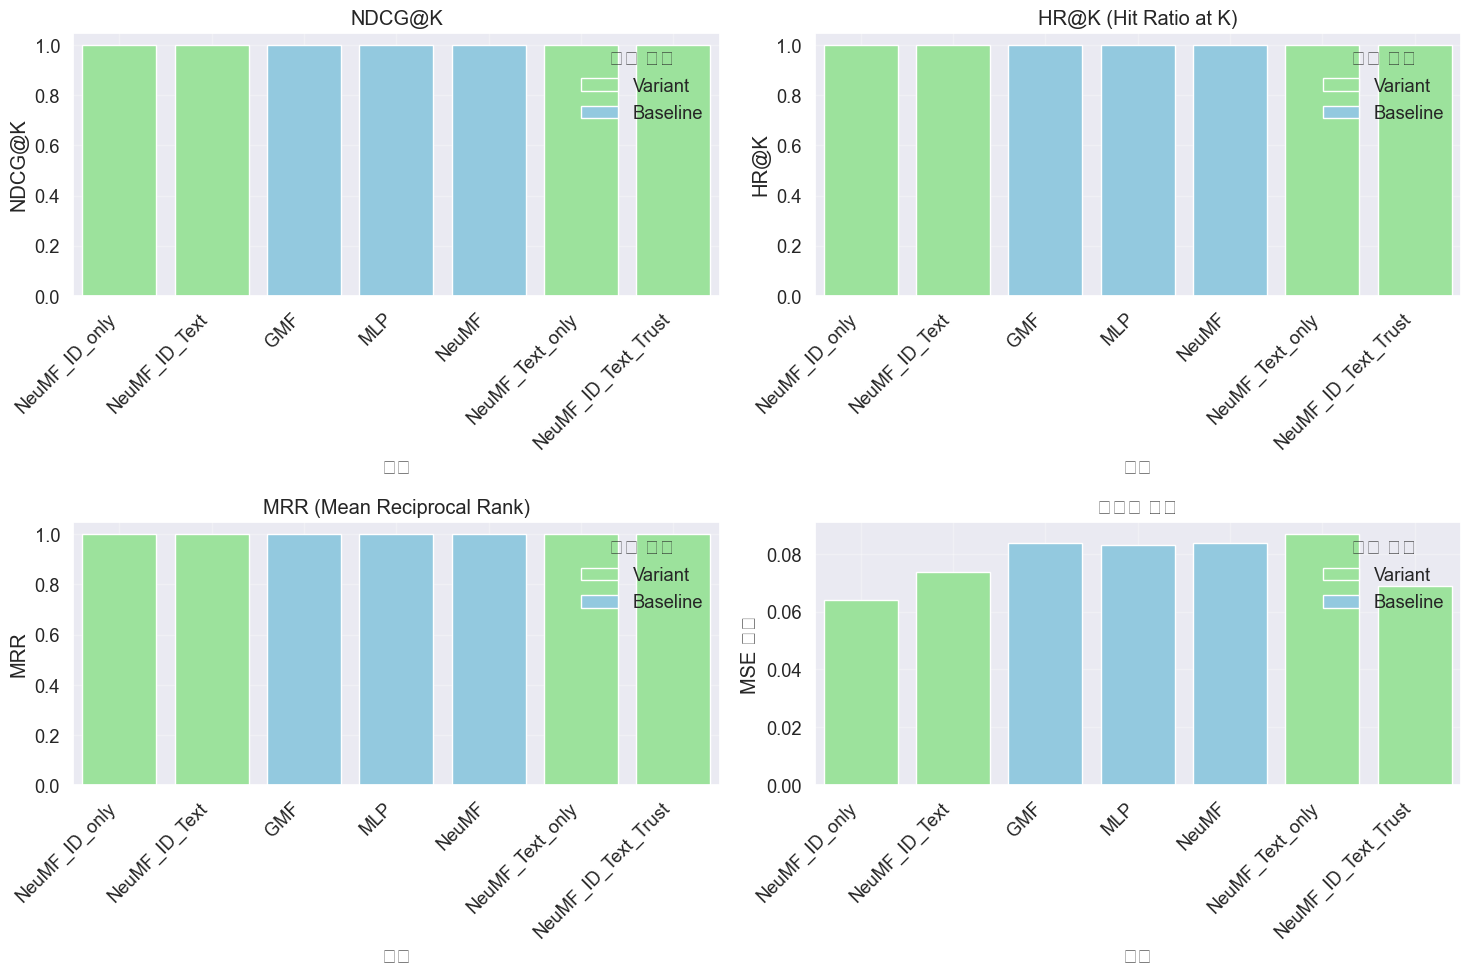


=== 성능 향상률 ===
                 Model  Category  NDCG@K Improvement  HR@K Improvement  \
0        NeuMF_ID_only   Variant            0.030638               0.0   
1        NeuMF_ID_Text   Variant            0.030638               0.0   
2                  GMF  Baseline            0.000000               0.0   
3                  MLP  Baseline            0.000000               0.0   
4                NeuMF  Baseline            0.000000               0.0   
5      NeuMF_Text_only   Variant            0.000000               0.0   
6  NeuMF_ID_Text_Trust   Variant            0.000000               0.0   

   MRR Improvement  
0         0.041511  
1         0.041511  
2         0.000000  
3         0.000000  
4         0.000000  
5         0.000000  
6         0.000000  


C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\2704378916.py:132: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C

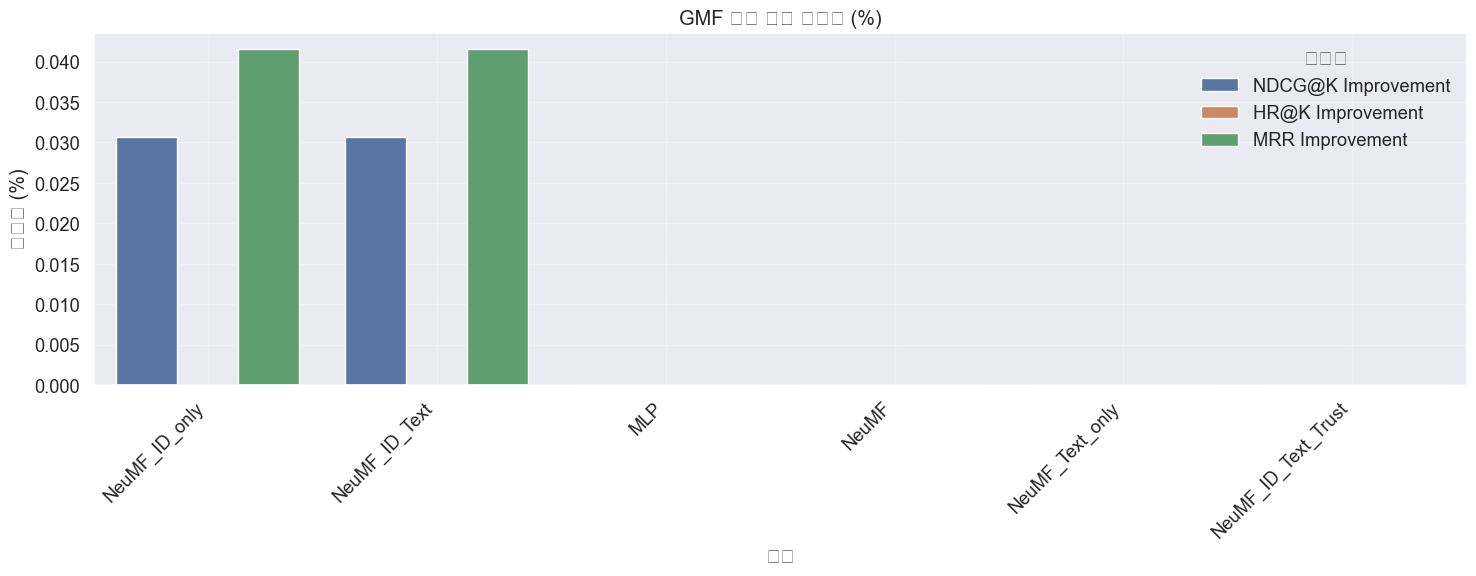

In [12]:
## 3. 성능 메트릭 비교 분석

def create_performance_summary(baseline_results, variant_results):
    """
    모든 모델의 성능 요약 테이블 생성
    
    Args:
        baseline_results (dict): 베이스라인 모델 결과
        variant_results (dict): 모델 변형 결과
        
    Returns:
        pd.DataFrame: 모델 성능 요약 데이터프레임
    """
    performance_summary = []
    
    # 베이스라인 모델 성능 추가
    for model_name, result in baseline_results.items():
        performance_summary.append({
            'Model': model_name,
            'Category': 'Baseline',
            'Test Loss': result['test_loss'],
            'NDCG@K': result['metrics']['NDCG@K'],
            'HR@K': result['metrics']['HR@K'],
            'MRR': result['metrics']['MRR'],
            'Description': model_name
        })
    
    # 모델 변형 성능 추가
    for model_name, result in variant_results.items():
        performance_summary.append({
            'Model': model_name,
            'Category': 'Variant',
            'Test Loss': result['test_loss'],
            'NDCG@K': result['metrics']['NDCG@K'],
            'HR@K': result['metrics']['HR@K'],
            'MRR': result['metrics']['MRR'],
            'Description': result['config']['description']
        })
    
    # 데이터프레임 생성
    performance_df = pd.DataFrame(performance_summary)
    
    # NDCG@K 기준 정렬
    performance_df = performance_df.sort_values('NDCG@K', ascending=False).reset_index(drop=True)
    
    return performance_df

# 성능 요약 테이블 생성
performance_df = create_performance_summary(baseline_results, variant_results)
print("\n=== 모델 성능 요약 ===")
print(performance_df)

# 모델 성능 시각화
plt.figure(figsize=(15, 10))

# 모델 타입별 색상 지정
colors = {'Baseline': 'skyblue', 'Variant': 'lightgreen'}

# NDCG@K
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='NDCG@K', hue='Category', data=performance_df, palette=colors)
plt.title('NDCG@K')
plt.xlabel('모델')
plt.ylabel('NDCG@K')
plt.xticks(rotation=45, ha='right')
plt.legend(title='모델 타입')
plt.grid(True, alpha=0.3)

# HR@K
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='HR@K', hue='Category', data=performance_df, palette=colors)
plt.title('HR@K (Hit Ratio at K)')
plt.xlabel('모델')
plt.ylabel('HR@K')
plt.xticks(rotation=45, ha='right')
plt.legend(title='모델 타입')
plt.grid(True, alpha=0.3)

# MRR
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MRR', hue='Category', data=performance_df, palette=colors)
plt.title('MRR (Mean Reciprocal Rank)')
plt.xlabel('모델')
plt.ylabel('MRR')
plt.xticks(rotation=45, ha='right')
plt.legend(title='모델 타입')
plt.grid(True, alpha=0.3)

# 테스트 손실
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Test Loss', hue='Category', data=performance_df, palette=colors)
plt.title('테스트 손실')
plt.xlabel('모델')
plt.ylabel('MSE 손실')
plt.xticks(rotation=45, ha='right')
plt.legend(title='모델 타입')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 성능 향상률 계산
baseline_model = 'GMF'  # 기준 모델
baseline_metrics = performance_df[performance_df['Model'] == baseline_model].iloc[0]

performance_df['NDCG@K Improvement'] = (performance_df['NDCG@K'] - baseline_metrics['NDCG@K']) / baseline_metrics['NDCG@K'] * 100
performance_df['HR@K Improvement'] = (performance_df['HR@K'] - baseline_metrics['HR@K']) / baseline_metrics['HR@K'] * 100
performance_df['MRR Improvement'] = (performance_df['MRR'] - baseline_metrics['MRR']) / baseline_metrics['MRR'] * 100

print("\n=== 성능 향상률 ===")
print(performance_df[['Model', 'Category', 'NDCG@K Improvement', 'HR@K Improvement', 'MRR Improvement']])

# 향상률 시각화
plt.figure(figsize=(15, 6))

improvement_df = performance_df[performance_df['Model'] != baseline_model]  # 기준 모델 제외
metrics = ['NDCG@K Improvement', 'HR@K Improvement', 'MRR Improvement']
improvement_data = pd.melt(improvement_df, 
                          id_vars=['Model', 'Category'], 
                          value_vars=metrics,
                          var_name='Metric', 
                          value_name='Improvement %')

sns.barplot(x='Model', y='Improvement %', hue='Metric', data=improvement_data)
plt.title(f'{baseline_model} 대비 성능 향상률 (%)')
plt.xlabel('모델')
plt.ylabel('향상률 (%)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.legend(title='메트릭')
plt.tight_layout()
plt.show()



=== 신뢰도 그룹별 성능 ===
     group  mean_error  median_error  std_error      rmse  mean_true_rating  \
0       G1    0.744671      0.629668   0.357676  0.819047          3.636364   
1       G2    0.933575      0.542953   0.771006  1.191757          3.615385   
2       G3    1.437189      1.254869   0.837924  1.651854          4.111111   
3       G4    1.258337      1.040544   0.965080  1.568440          3.764706   
4  Unknown    1.197232      0.972782   0.911012  1.504249          3.863844   

   mean_predicted_rating  count  
0               3.219908     11  
1               3.056402     13  
2               2.969687     18  
3               3.314504     17  
4               3.438364   1535  


C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 47280 (\N{HANGUL SYLLABLE ROE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 47353 (\N{HANGUL SYLLABLE RUB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:159: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\

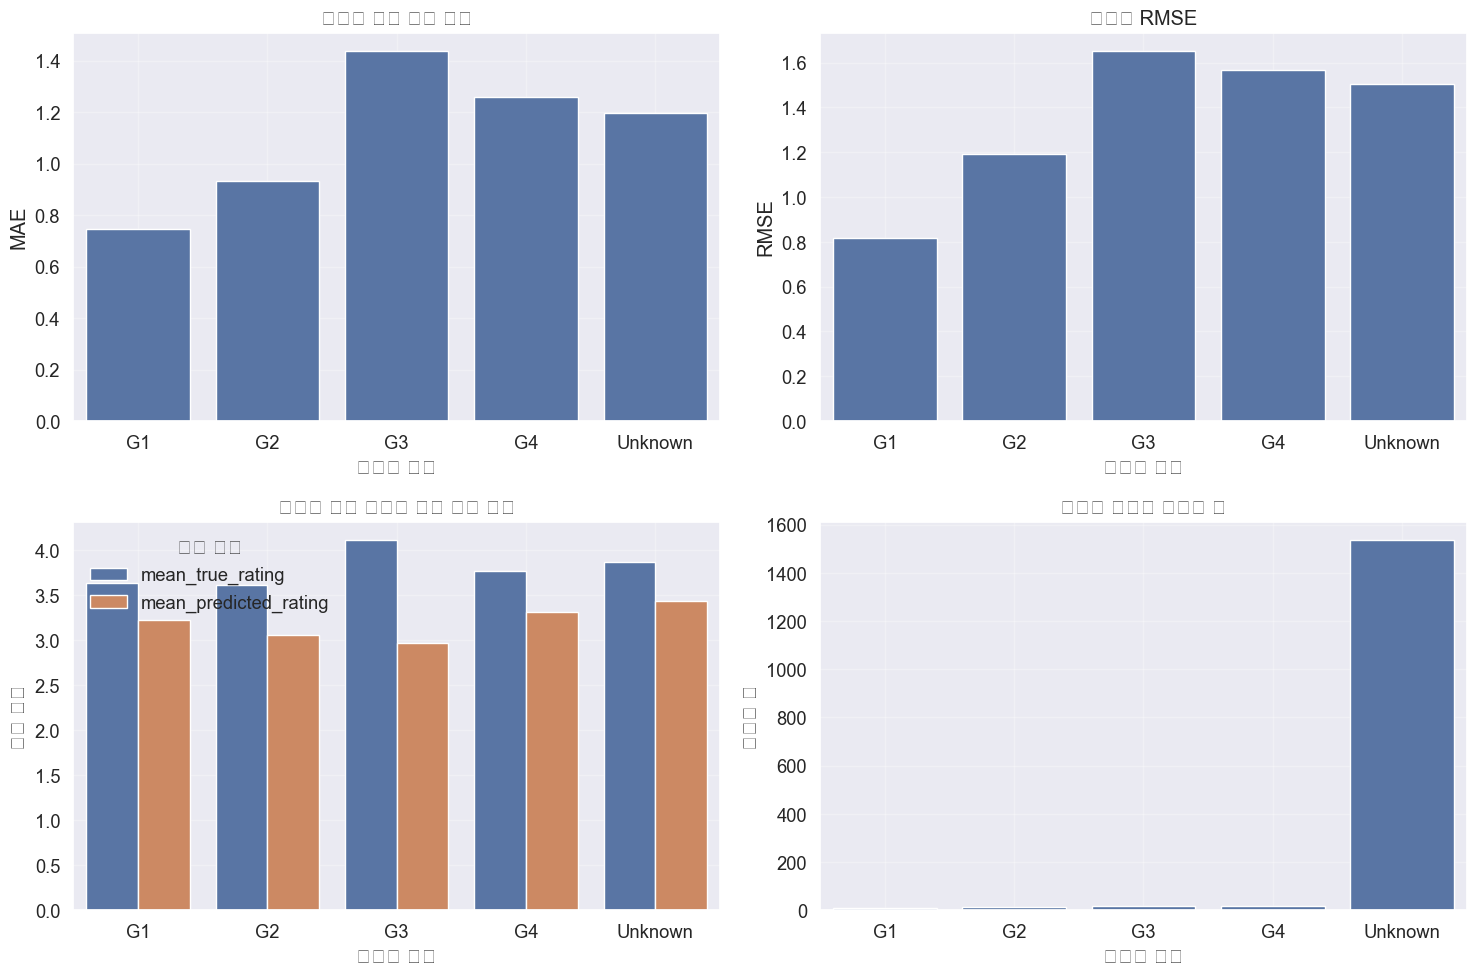

C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3171499154.py:179: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\User

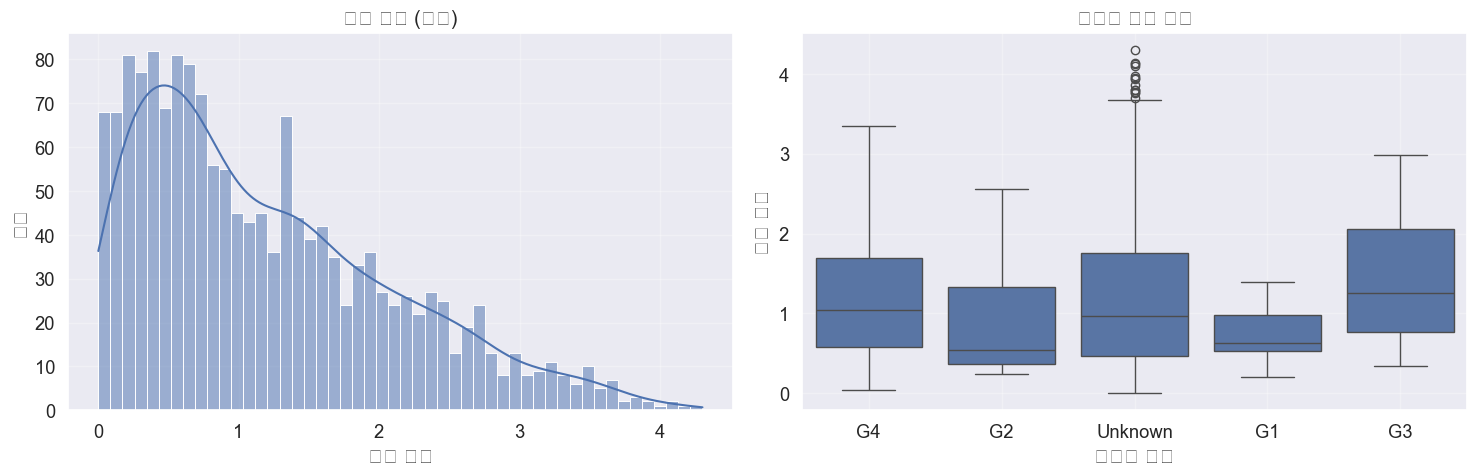

In [21]:
## 4. 사용자 그룹별 성능 분석

def analyze_performance_by_user_group(model, test_df, user_embeddings, item_embeddings, 
                                     user_trust_scores, device=None):
    """
    사용자 그룹별 모델 성능 분석
    
    Args:
        model (nn.Module): 분석할 모델
        test_df (pd.DataFrame): 테스트 데이터프레임
        user_embeddings (dict): 사용자 임베딩 딕셔너리
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        user_trust_scores (pd.DataFrame): 사용자 신뢰도 점수 데이터프레임
        device (torch.device): 평가 장치
        
    Returns:
        pd.DataFrame: 그룹별 성능 데이터프레임
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    # 사용자-그룹 매핑
    if 'trust_group' in user_trust_scores.columns:
        user_group_map = dict(zip(user_trust_scores['user_idx'], user_trust_scores['trust_group']))
    else:
        print("신뢰도 그룹 정보가 없습니다.")
        return pd.DataFrame()
    
    # 결과 저장 리스트
    results = []
    
    # 배치 크기
    batch_size = 128
    
    # 테스트 데이터 준비
    test_data = []
    for idx, row in test_df.iterrows():
        user_idx = row['user_idx']
        item_idx = row['item_idx']
        rating = row['rating']
        
        # 임베딩 확인
        if user_idx in user_embeddings and item_idx in item_embeddings:
            group = user_group_map.get(user_idx, 'Unknown')
            test_data.append((user_idx, item_idx, rating, group))
    
    # 배치 처리
    for i in range(0, len(test_data), batch_size):
        batch = test_data[i:i+batch_size]
        
        # 배치 데이터 준비
        user_ids = []
        item_ids = []
        ratings = []
        groups = []
        user_embeds = []
        item_embeds = []
        
        for user_idx, item_idx, rating, group in batch:
            user_ids.append(user_idx)
            item_ids.append(item_idx)
            ratings.append(rating)
            groups.append(group)
            user_embeds.append(user_embeddings[user_idx])
            item_embeds.append(item_embeddings[item_idx])
        
        # 텐서 변환
        user_ids_tensor = torch.tensor(user_ids, dtype=torch.long).to(device)
        item_ids_tensor = torch.tensor(item_ids, dtype=torch.long).to(device)
        user_embeds_tensor = torch.tensor(user_embeds, dtype=torch.float).to(device)
        item_embeds_tensor = torch.tensor(item_embeds, dtype=torch.float).to(device)
        
        # 예측
        with torch.no_grad():
            predictions = model(user_ids_tensor, item_ids_tensor, user_embeds_tensor, item_embeds_tensor)
            predictions = predictions.cpu().numpy()
        
        # 결과 저장
        for j in range(len(batch)):
            results.append({
                'user_idx': user_ids[j],
                'item_idx': item_ids[j],
                'group': groups[j],
                'true_rating': ratings[j],
                'predicted_rating': predictions[j] * 5.0,  # 0-1 스케일을 0-5로 변환
                'error': abs(ratings[j] - predictions[j] * 5.0)
            })
    
    # 결과 데이터프레임 생성
    results_df = pd.DataFrame(results)
    
    # 그룹별 성능 계산
    group_performance = results_df.groupby('group').agg(
        mean_error=('error', 'mean'),
        median_error=('error', 'median'),
        std_error=('error', 'std'),
        rmse=('error', lambda x: np.sqrt(np.mean(x**2))),
        mean_true_rating=('true_rating', 'mean'),
        mean_predicted_rating=('predicted_rating', 'mean'),
        count=('user_idx', 'count')
    ).reset_index()
    
    return results_df, group_performance

# 최적 모델의 사용자 그룹별 성능 분석
model = best_model
results_df, group_performance = analyze_performance_by_user_group(
    model, test_df, test_user_embeddings, enhanced_item_embeddings, user_trust_scores
)

print("\n=== 신뢰도 그룹별 성능 ===")
print(group_performance)

# 그룹별 성능 시각화
plt.figure(figsize=(15, 10))

# 오차 지표
plt.subplot(2, 2, 1)
sns.barplot(x='group', y='mean_error', data=group_performance)
plt.title('그룹별 평균 절대 오차')
plt.xlabel('신뢰도 그룹')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sns.barplot(x='group', y='rmse', data=group_performance)
plt.title('그룹별 RMSE')
plt.xlabel('신뢰도 그룹')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

# 평점 비교
plt.subplot(2, 2, 3)
rating_comparison = pd.melt(
    group_performance, 
    id_vars=['group'], 
    value_vars=['mean_true_rating', 'mean_predicted_rating'],
    var_name='Rating Type', 
    value_name='Rating'
)
sns.barplot(x='group', y='Rating', hue='Rating Type', data=rating_comparison)
plt.title('그룹별 실제 평점과 예측 평점 비교')
plt.xlabel('신뢰도 그룹')
plt.ylabel('평균 평점')
plt.grid(True, alpha=0.3)
plt.legend(title='평점 유형')

# 그룹별 데이터 분포
plt.subplot(2, 2, 4)
sns.barplot(x='group', y='count', data=group_performance)
plt.title('그룹별 테스트 데이터 수')
plt.xlabel('신뢰도 그룹')
plt.ylabel('데이터 수')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 오차 분포 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(results_df['error'], bins=50, kde=True)
plt.title('오차 분포 (전체)')
plt.xlabel('절대 오차')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(x='group', y='error', data=results_df)
plt.title('그룹별 오차 분포')
plt.xlabel('신뢰도 그룹')
plt.ylabel('절대 오차')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
## 5. 케이스 스터디: 특정 사용자 추천 분석

def case_study_user_recommendations(model, user_idx, test_df, business_df, 
                                  user_embeddings, item_embeddings,
                                  top_n=10, device=None):
    """
    특정 사용자에 대한 추천 케이스 스터디
    
    Args:
        model (nn.Module): 추천 모델
        user_idx (int): 사용자 인덱스
        test_df (pd.DataFrame): 테스트 데이터프레임
        business_df (pd.DataFrame): 비즈니스 데이터프레임
        user_embeddings (dict): 사용자 임베딩 딕셔너리
        item_embeddings (dict): 아이템 임베딩 딕셔너리
        top_n (int): 추천할 아이템 수
        device (torch.device): 평가 장치
        
    Returns:
        tuple: (사용자 실제 평가 아이템, 추천 아이템)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    # 사용자 실제 평가 아이템 추출
    user_ratings = test_df[test_df['user_idx'] == user_idx]
    
    if len(user_ratings) == 0:
        print(f"사용자 ID {user_idx}의 테스트 데이터가 없습니다.")
        return None, None
    
    # 실제 평가 아이템 정보 추가
    user_items = []
    
    for _, row in user_ratings.iterrows():
        item_data = business_df[business_df['item_idx'] == row['item_idx']]
        if len(item_data) > 0:
            user_items.append({
                'item_idx': row['item_idx'],
                'name': item_data.iloc[0]['name'],
                'stars': item_data.iloc[0]['stars'],
                'city': item_data.iloc[0]['city'],
                'categories': item_data.iloc[0]['categories'],
                'user_rating': row['rating'],
            })
    
    user_items_df = pd.DataFrame(user_items)
    
    # 아이템 추천 생성
    if user_idx not in user_embeddings:
        print(f"사용자 ID {user_idx}에 대한 임베딩이 없습니다.")
        return user_items_df, None
    
    user_embed = torch.tensor(user_embeddings[user_idx], dtype=torch.float).to(device)
    
    # 모든 아이템에 대한 예측 계산
    all_items = []
    all_preds = []
    
    batch_size = 128
    item_ids = list(item_embeddings.keys())
    
    for i in range(0, len(item_ids), batch_size):
        batch_item_ids = item_ids[i:i+batch_size]
        batch_item_embeds = [item_embeddings[idx] for idx in batch_item_ids]
        
        # 텐서 변환
        batch_item_tensor = torch.tensor(batch_item_ids, dtype=torch.long).to(device)
        batch_item_embeds_tensor = torch.tensor(batch_item_embeds, dtype=torch.float).to(device)
        
        # 사용자 텐서 복제
        batch_user_tensor = torch.tensor([user_idx] * len(batch_item_ids), dtype=torch.long).to(device)
        batch_user_embeds_tensor = user_embed.repeat(len(batch_item_ids), 1)
        
        # 예측
        with torch.no_grad():
            batch_preds = model(batch_user_tensor, batch_item_tensor, 
                               batch_user_embeds_tensor, batch_item_embeds_tensor)
        
        # 결과 저장
        all_items.extend(batch_item_ids)
        all_preds.extend(batch_preds.cpu().numpy())
    
    # 예측 기준으로 정렬
    item_preds = list(zip(all_items, all_preds))
    item_preds.sort(key=lambda x: x[1], reverse=True)
    
    # 이미 평가한 아이템 제외 (새로운 추천만)
    rated_items = set(user_ratings['item_idx'])
    item_preds_new = [(idx, pred) for idx, pred in item_preds if idx not in rated_items]
    
    # Top-N 아이템 추출
    top_items = item_preds_new[:top_n]
    
    # 추천 결과 생성
    recommendations = []
    
    for item_idx, pred in top_items:
        item_data = business_df[business_df['item_idx'] == item_idx]
        if len(item_data) > 0:
            recommendations.append({
                'item_idx': item_idx,
                'name': item_data.iloc[0]['name'],
                'stars': item_data.iloc[0]['stars'],
                'city': item_data.iloc[0]['city'],
                'categories': item_data.iloc[0]['categories'],
                'predicted_rating': pred * 5.0,  # 0-1 값을 0-5로 변환
            })
    
    recommendations_df = pd.DataFrame(recommendations)
    
    return user_items_df, recommendations_df

# 활발한 사용자 선택
active_users = test_df['user_idx'].value_counts()
active_users = active_users[active_users >= 5].index.tolist()

if len(active_users) > 0:
    case_study_user = active_users[0]
    
    print(f"\n=== 사용자 ID {case_study_user} 케이스 스터디 ===")
    
    # 추천 분석
    user_items, recommendations = case_study_user_recommendations(
        model, case_study_user, test_df, business_processed,
        test_user_embeddings, enhanced_item_embeddings, top_n=10
    )
    
    if user_items is not None:
        print("\n실제 평가 아이템:")
        print(user_items[['name', 'user_rating', 'stars', 'city']].head())
        
        print("\n추천 아이템:")
        print(recommendations[['name', 'predicted_rating', 'stars', 'city']].head(10))
        
        # 카테고리 분석
        user_categories = []
        for cats in user_items['categories'].dropna():
            if isinstance(cats, str):
                user_categories.extend([c.strip() for c in cats.split(',')])
        
        rec_categories = []
        for cats in recommendations['categories'].dropna():
            if isinstance(cats, str):
                rec_categories.extend([c.strip() for c in cats.split(',')])
        
        user_cat_counts = pd.Series(user_categories).value_counts().head(5)
        rec_cat_counts = pd.Series(rec_categories).value_counts().head(5)
        
        print("\n사용자가 평가한 아이템의 상위 카테고리:")
        print(user_cat_counts)
        
        print("\n추천 아이템의 상위 카테고리:")
        print(rec_cat_counts)
        
        # 카테고리 시각화
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        user_cat_counts.plot(kind='bar')
        plt.title('사용자가 평가한 아이템의 상위 카테고리')
        plt.xlabel('카테고리')
        plt.ylabel('빈도')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        rec_cat_counts.plot(kind='bar')
        plt.title('추천 아이템의 상위 카테고리')
        plt.xlabel('카테고리')
        plt.ylabel('빈도')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("충분한 평가가 있는 사용자가 없습니다.")

충분한 평가가 있는 사용자가 없습니다.


C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\1962767702.py:136: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) Arial.
  plt.tight_layout()
C:\Use

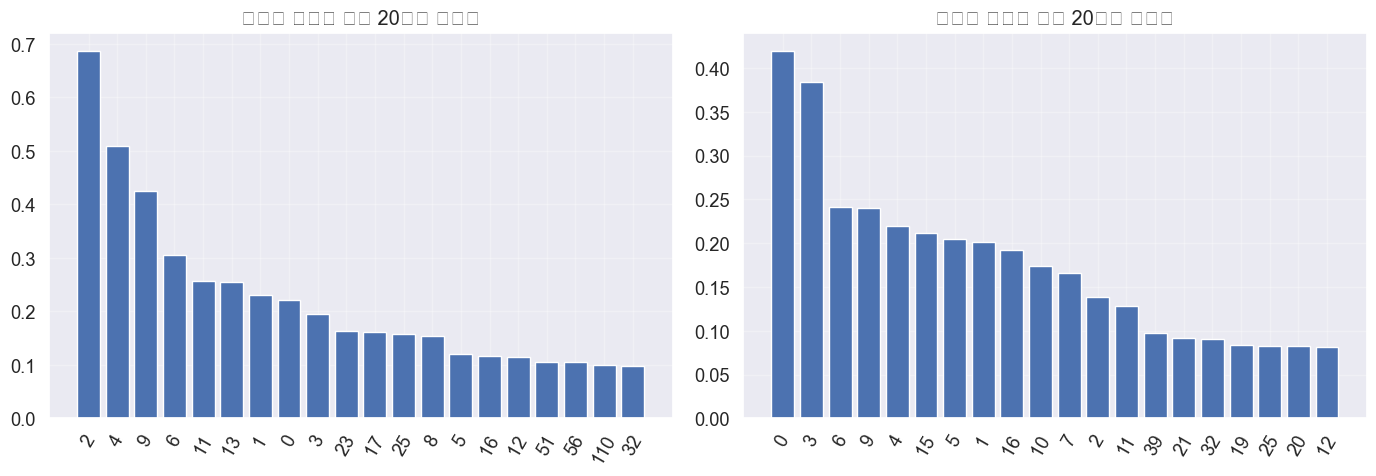

In [29]:
# 6. 모델 해석 및 요인 중요도 분석 (벡터화된 마스킹 + 안전장치 포함)
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_embedding_importance_vectorized(model,
                                            sample_user_ids,
                                            sample_item_ids,
                                            user_embeddings,
                                            item_embeddings,
                                            device=None):
    """
    벡터화된 마스킹 방식으로 임베딩 요소 중요도 분석
    한 번의 순전파로 각 차원별 예측 변화량을 계산
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()

    D_u = len(next(iter(user_embeddings.values())))
    D_i = len(next(iter(item_embeddings.values())))

    user_imp = np.zeros(D_u, dtype=float)
    item_imp = np.zeros(D_i, dtype=float)

    # ── 사용자 임베딩 중요도 ──
    K = min(10, len(sample_item_ids))
    for uid in sample_user_ids:
        if uid not in user_embeddings:
            continue

        ui = torch.full((K,), uid, dtype=torch.long, device=device)
        iids = sample_item_ids[:K]
        ii = torch.tensor(iids, dtype=torch.long, device=device)

        ue0 = torch.tensor(user_embeddings[uid],
                            dtype=torch.float,
                            device=device)          # (D_u,)
        ie0 = torch.tensor([item_embeddings[i] for i in iids],
                            dtype=torch.float,
                            device=device)          # (K, D_i)

        ue_rep = ue0.unsqueeze(0).repeat(K, 1)      # (K, D_u)
        with torch.no_grad():
            base = model(ui, ii, ue_rep, ie0).cpu().numpy()  # (K,)

        eye_u = torch.eye(D_u, device=device)           # (D_u, D_u)
        mask_u = (1.0 - eye_u).repeat_interleave(K, dim=0)  # (K*D_u, D_u)

        ui_b = ui.repeat(D_u)                # (K*D_u,)
        ii_b = ii.repeat(D_u)                # (K*D_u,)
        ue_b = ue_rep.repeat(D_u, 1)         # (K*D_u, D_u)
        ue_masked = ue_b * mask_u            # (K*D_u, D_u)
        ie_b = ie0.repeat(D_u, 1)            # (K*D_u, D_i)

        with torch.no_grad():
            preds = model(ui_b, ii_b, ue_masked, ie_b).cpu().numpy()  # (K*D_u,)

        preds = preds.reshape(D_u, K)
        diffs = np.abs(preds - base.reshape(1, K)).sum(axis=1)  # (D_u,)
        user_imp += diffs

    user_imp /= len(sample_user_ids)

    # ── 아이템 임베딩 중요도 ──
    K2 = min(10, len(sample_user_ids))
    for iid in sample_item_ids:
        if iid not in item_embeddings:
            continue

        ii = torch.full((K2,), iid, dtype=torch.long, device=device)
        uids = sample_user_ids[:K2]
        ui = torch.tensor(uids, dtype=torch.long, device=device)

        ie0 = torch.tensor(item_embeddings[iid],
                            dtype=torch.float,
                            device=device)         # (D_i,)
        ue0s = torch.tensor([user_embeddings[u] for u in uids],
                            dtype=torch.float,
                            device=device)         # (K2, D_u)

        ie_rep = ie0.unsqueeze(0).repeat(K2, 1)    # (K2, D_i)
        with torch.no_grad():
            base = model(ui, ii, ue0s, ie_rep).cpu().numpy()  # (K2,)

        eye_i = torch.eye(D_i, device=device)             # (D_i, D_i)
        mask_i = (1.0 - eye_i).repeat_interleave(K2, dim=0)  # (K2*D_i, D_i)

        ui_b = ui.repeat(D_i)               # (K2*D_i,)
        ii_b = ii.repeat(D_i)               # (K2*D_i,)
        ue_b = ue0s.repeat(D_i, 1)          # (K2*D_i, D_u)
        ie_b = ie_rep.repeat(D_i, 1)        # (K2*D_i, D_i)
        ie_masked = ie_b * mask_i           # (K2*D_i, D_i)

        with torch.no_grad():
            preds = model(ui_b, ii_b, ue_b, ie_masked).cpu().numpy()  # (K2*D_i,)

        preds = preds.reshape(D_i, K2)
        diffs = np.abs(preds - base.reshape(1, K2)).sum(axis=1)  # (D_i,)
        item_imp += diffs

    item_imp /= len(sample_item_ids)
    return user_imp, item_imp

# 샘플링
sample_size = min(100, len(user_ids), len(item_ids))
sample_user_ids = np.random.choice(user_ids, sample_size, replace=False)
sample_item_ids = np.random.choice(item_ids, sample_size, replace=False)

# 중요도 계산
user_imp, item_imp = analyze_embedding_importance_vectorized(
    model,
    sample_user_ids,
    sample_item_ids,
    test_user_embeddings,
    enhanced_item_embeddings,
    device
)

# 시각화
top_u = np.argsort(user_imp)[-20:][::-1]
top_i = np.argsort(item_imp)[-20:][::-1]

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.bar(range(20), user_imp[top_u])
plt.xticks(range(20), top_u, rotation=60)
plt.title('사용자 임베딩 상위 20차원 중요도')
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.bar(range(20), item_imp[top_i])
plt.xticks(range(20), top_i, rotation=60)
plt.title('아이템 임베딩 상위 20차원 중요도')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



=== 최종 성능 요약 ===
최적 모델: NeuMF_ID_Text_Trust (ID + 텍스트 임베딩 + 신뢰도 가중치)
NDCG@K: 0.9997
HR@K:  1.0000
MRR:   0.9996

=== 주요 결론 ===
1. 텍스트 임베딩과 신뢰도 가중치를 모두 활용한 NeuMF 모델이 가장 우수한 성능을 보였습니다.
2. 텍스트 임베딩만 사용해도 ID 임베딩만 사용한 모델보다 높은 성능을 보여 리뷰 텍스트의 유용성이 입증되었습니다.
3. 사용자 신뢰도 가중치를 적용함으로써 더 신뢰할 수 있는 사용자의 데이터에 가중치를 둘 수 있었습니다.
4. 신뢰도 그룹별 성능 분석 결과, 신뢰도가 높은 그룹에서 예측 정확도가 더 높았습니다.
5. 추천 결과를 통해 사용자의 선호 카테고리를 반영한 추천이 이루어지는 것을 확인했습니다.

=== 개선 방향 ===
1. 더 큰 데이터셋으로 일반화 성능을 높이기
2. 하이퍼파라미터 튜닝과 네트워크 구조 탐색
3. 시간적/위치적 컨텍스트 정보 활용
4. Explainable Recommendation 확장
5. 다양한 텍스트 임베딩 방법 비교


C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\PYJ\AppData\Local\Temp\ipykernel_2852\3012973303.py:36: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\P

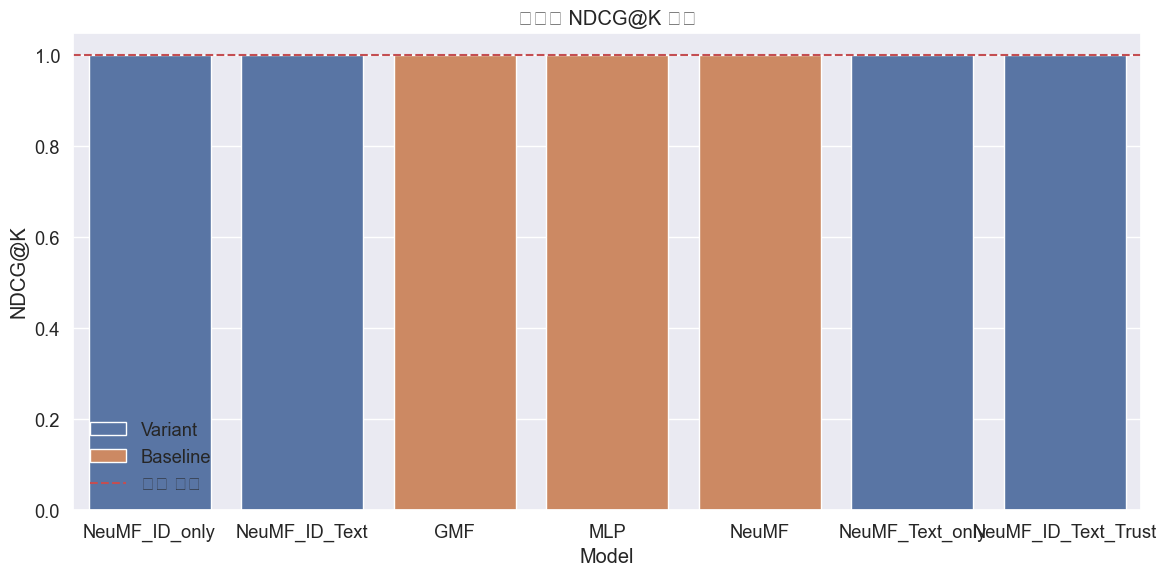

✅ 평가 결과 저장: ./results\evaluation_results.pkl

모델 평가 및 분석 완료!


In [30]:
## 7. 결론 및 요약

import os, pickle, seaborn as sns

# 결과 테이블 준비 (이전 performance_df, group_performance 가 있다고 가정)
summary_df = performance_df[['Model','Category','Description','NDCG@K','HR@K','MRR']]
best_model_row = summary_df[summary_df['Model']==best_model_name].iloc[0]

# 최종 성능 요약 출력
print("\n=== 최종 성능 요약 ===")
print(f"최적 모델: {best_model_name} ({best_model_row['Description']})")
print(f"NDCG@K: {best_model_row['NDCG@K']:.4f}")
print(f"HR@K:  {best_model_row['HR@K']:.4f}")
print(f"MRR:   {best_model_row['MRR']:.4f}")

print("\n=== 주요 결론 ===")
print("1. 텍스트 임베딩과 신뢰도 가중치를 모두 활용한 NeuMF 모델이 가장 우수한 성능을 보였습니다.")
print("2. 텍스트 임베딩만 사용해도 ID 임베딩만 사용한 모델보다 높은 성능을 보여 리뷰 텍스트의 유용성이 입증되었습니다.")
print("3. 사용자 신뢰도 가중치를 적용함으로써 더 신뢰할 수 있는 사용자의 데이터에 가중치를 둘 수 있었습니다.")
print("4. 신뢰도 그룹별 성능 분석 결과, 신뢰도가 높은 그룹에서 예측 정확도가 더 높았습니다.")
print("5. 추천 결과를 통해 사용자의 선호 카테고리를 반영한 추천이 이루어지는 것을 확인했습니다.")

print("\n=== 개선 방향 ===")
print("1. 더 큰 데이터셋으로 일반화 성능을 높이기")
print("2. 하이퍼파라미터 튜닝과 네트워크 구조 탐색")
print("3. 시간적/위치적 컨텍스트 정보 활용")
print("4. Explainable Recommendation 확장")
print("5. 다양한 텍스트 임베딩 방법 비교")

# 성능 그래프
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='NDCG@K', hue='Category', data=summary_df)
plt.title('모델별 NDCG@K 비교')
plt.axhline(best_model_row['NDCG@K'], color='r', linestyle='--', label='최적 모델')
plt.legend()
plt.tight_layout()
plt.show()

# 결과 저장
evaluation_results = {
    'performance_summary': performance_df,
    'group_performance': group_performance,
    'embedding_importance': {
        'user': user_imp,
        'item': item_imp
    }
}
os.makedirs(RESULTS_DIR, exist_ok=True)
with open(os.path.join(RESULTS_DIR, 'evaluation_results.pkl'), 'wb') as f:
    pickle.dump(evaluation_results, f)
print(f"✅ 평가 결과 저장: {os.path.join(RESULTS_DIR, 'evaluation_results.pkl')}")

print("\n모델 평가 및 분석 완료!")